In [1]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to Tensors
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

C:\Users\9931168\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


C:\Users\9931168\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


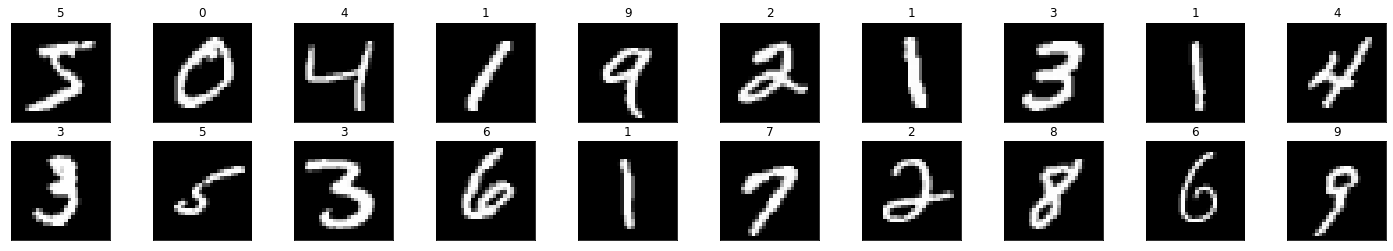

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [6]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [7]:
import torch
import torch.nn.functional as F

def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

In [8]:
#import helpers # to get transpose softmax function

# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = softmax(b_ij, dim=2)
         #helpers.
        

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j

In [9]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = False#torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Only CPU available


In [10]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, 
                 in_channels=8, out_channels=16):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 1152
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        # 4D weight matrix
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())
        
        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

In [12]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        #print(caps_output.type(), caps_output.size())
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y

In [13]:
# instantiate and print net
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()

capsule_net = CapsuleNetwork()

print(capsule_net)


# move model to GPU, if available 
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

In [14]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [15]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

In [16]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=300):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses = []

    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):

            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses

In [ ]:
# training for 3 epochs
n_epochs = 3
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

In [17]:
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponding reconstructions
       '''
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    test_loss = 0 # loss tracking

    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)

        batch_size = images.size(0)

        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [230]:
#load the model


from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


capsule_net.load_state_dict(torch.load('./model-parameters.pt'))

capsule_net = CapsuleNetwork().to(device)


capsule_net.eval()
pre_trained_dict = capsule_net.state_dict()

mystr =  'primary_capsules.capsules.' + str(7) + '.bias'
print(mystr)
primary_caps = pre_trained_dict[mystr][0].item()

print(type(primary_caps))

weight_tensor = pre_trained_dict['digit_capsules.W']

print(weight_tensor.size())

#print(weight_tensor.size())
#print(weight_tensor)

#print('none zero weights count: ', torch.count_nonzero(weight_tensor))
#print('number of all tensor cells: ', torch.numel(weight_tensor))

#pre_trained_dict['primary_capsules.capsules.1.weight'] = torch.zeros(32, 256, 9, 9, dtype=torch.float)

#conv_weights = a
#print(a.size())
#print(a)
#print(pre_trained_dict['digit_capsules.W'])



#PRINTING NETWORK PARAMETERS
#for name, param in capsule_net.named_parameters():
#    if param.requires_grad:
#        print(name, param.type())

#summary(capsule_net, input_size=(1, 28, 28))


primary_capsules.capsules.7.bias
<class 'float'>
torch.Size([10, 1152, 8, 16])


In [69]:
%%time
# call test function and get reconstructed images
capsule_net.load_state_dict(torch.load('./model-parameters.pt'))
capsule_net.eval()
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.03458104

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 99% (976/982)
Test Accuracy of     5: 99% (888/892)
Test Accuracy of     6: 99% (951/958)
Test Accuracy of     7: 99% (1019/1028)
Test Accuracy of     8: 98% (964/974)
Test Accuracy of     9: 96% (977/1009)

Test Accuracy (Overall): 99% (9902/10000)
Wall time: 47.9 s


In [ ]:
import struct
def float_to_bin(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

def bin_to_float(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

In [18]:
%%time
from utils import float2bit
from utils import bit2float
import math

#capsule_net.load_state_dict(torch.load('./model-parameters.pt'))

#capsule_net.eval()

#summary(capsule_net, input_size=(1, 28, 28))

#state_dict = capsule_net.state_dict()


#print(state_dict['digit_capsules.W'][0, 0, 0, 0], '\n')


#binary_tensor = float2bit(state_dict['digit_capsules.W'], num_e_bits=8, num_m_bits=23, bias=127.)



#print(torch.reshape(binary_tensor, (-1,)).size(), '\n')

#print(torch.reshape(binary_tensor, (-1,))[0].item(), '\n')

#torch.reshape(binary_tensor, (-1,))[0] = float(0)

#print(torch.reshape(binary_tensor, (-1,))[0].item(), '\n')

#print(type(torch.reshape(binary_tensor, (-1,))[47185919].item()), '\n')


# validity test  ###############################################

#for i in range (1, 9):
    #torch.reshape(state_dict['digit_capsules.W'] , (-1,))[random_tensor_index].item()
 #   binary_tensor[0, 0, 0, 0][i] = float(1)

#for i in range (9, 32):
#    binary_tensor[0, 0, 0, 0][i] = float(0)


#print((binary_tensor[0, 0, 0, 0]), '\n')



#float_tensor = bit2float(binary_tensor, num_e_bits=8, num_m_bits=23, bias=127.)

#print(math.isfinite(float_tensor[0, 0, 0, 0]))


#print(float_tensor[0, 0, 0, 0])

##################################################################


## Fault injection ###############################################

import random

number_of_bit_flips = 1000000

exponential_fault_growth = 113000000

while exponential_fault_growth < 169869311:

    capsule_net.load_state_dict(torch.load('./model-parameters.pt'))

    capsule_net.eval()

    state_dict = capsule_net.state_dict()

    #binary_primary_caps_0 = float2bit(state_dict['primary_capsules.capsules.0.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_1 = float2bit(state_dict['primary_capsules.capsules.1.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_2 = float2bit(state_dict['primary_capsules.capsules.2.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_3 = float2bit(state_dict['primary_capsules.capsules.3.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_4 = float2bit(state_dict['primary_capsules.capsules.4.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_5 = float2bit(state_dict['primary_capsules.capsules.5.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_6 = float2bit(state_dict['primary_capsules.capsules.6.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_primary_caps_7 = float2bit(state_dict['primary_capsules.capsules.7.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

    #binary_tensor = float2bit(state_dict['digit_capsules.W'], num_e_bits=8, num_m_bits=23, bias=127.)

    temp = torch.cat((state_dict['primary_capsules.capsules.0.weight'],
                      state_dict['primary_capsules.capsules.1.weight'],
                      state_dict['primary_capsules.capsules.2.weight'],
                      state_dict['primary_capsules.capsules.3.weight'],
                      state_dict['primary_capsules.capsules.4.weight'],
                      state_dict['primary_capsules.capsules.5.weight'],
                      state_dict['primary_capsules.capsules.6.weight'], 
                      state_dict['primary_capsules.capsules.7.weight']), dim=0)

    primary_caps_tensor = float2bit(temp, num_e_bits=8, num_m_bits=23, bias=127.)

    
    for i in range (exponential_fault_growth):

        random_bit_number = random.randint(0, 169869311)  

        if( torch.reshape(primary_caps_tensor, (-1,))[random_bit_number] == float(0) ):

            torch.reshape(primary_caps_tensor, (-1,))[random_bit_number] = float(1)

        if( torch.reshape(primary_caps_tensor, (-1,))[random_bit_number] == float(1) ):

            torch.reshape(primary_caps_tensor, (-1,))[random_bit_number] = float(0)


    print("Number of Faults Injected: ", exponential_fault_growth, '\n')

    exponential_fault_growth = exponential_fault_growth + 1000000

    float_tensor = bit2float(primary_caps_tensor, num_e_bits=8, num_m_bits=23, bias=127.)

    final_tensor = torch.split(float_tensor, 32)

    state_dict['primary_capsules.capsules.0.weight'] = final_tensor[0]
    state_dict['primary_capsules.capsules.1.weight'] = final_tensor[1]
    state_dict['primary_capsules.capsules.2.weight'] = final_tensor[2]
    state_dict['primary_capsules.capsules.3.weight'] = final_tensor[3]
    state_dict['primary_capsules.capsules.4.weight'] = final_tensor[4]
    state_dict['primary_capsules.capsules.5.weight'] = final_tensor[5]
    state_dict['primary_capsules.capsules.6.weight'] = final_tensor[6]
    state_dict['primary_capsules.capsules.7.weight'] = final_tensor[7]

    #for i in range (6631551):
    #    if (math.isfinite(torch.reshape(float_tensor, (-1,))[i]) == False):
    #     print("EROOOOOOOOOOOOOOOOOR")

    #state_dict['digit_capsules.W'] = float_tensor
    capsule_net.load_state_dict(state_dict)
    capsule_net.eval()
    caps_output, images, reconstructions = test(capsule_net, test_loader)




    print("*************************************************************************", '\n')







Number of Faults Injected:  113000000 

Test Loss: 0.91409494

Test Accuracy of     0: 96% (944/980)
Test Accuracy of     1: 22% (256/1135)
Test Accuracy of     2: 88% (912/1032)
Test Accuracy of     3: 41% (417/1010)
Test Accuracy of     4: 99% (980/982)
Test Accuracy of     5: 85% (760/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 87% (903/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 91% (920/1009)

Test Accuracy (Overall): 79% (7987/10000)
************************************************************************* 

Number of Faults Injected:  114000000 

Test Loss: 0.91523761

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 32% (368/1135)
Test Accuracy of     2: 79% (820/1032)
Test Accuracy of     3:  8% (84/1010)
Test Accuracy of     4: 99% (978/982)
Test Accuracy of     5: 93% (830/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 94% (972/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 7

In [74]:
capsule_net.load_state_dict(torch.load('./model-parameters.pt'))

capsule_net.eval()

state_dict = capsule_net.state_dict()

print(state_dict['primary_capsules.capsules.0.weight'].size())
print(state_dict['primary_capsules.capsules.1.weight'].size())

temp = torch.cat((state_dict['primary_capsules.capsules.0.weight'],
                    state_dict['primary_capsules.capsules.1.weight'],
                    state_dict['primary_capsules.capsules.2.weight'],
                    state_dict['primary_capsules.capsules.3.weight'],
                    state_dict['primary_capsules.capsules.4.weight'],
                    state_dict['primary_capsules.capsules.5.weight'],
                    state_dict['primary_capsules.capsules.6.weight'], 
                    state_dict['primary_capsules.capsules.7.weight']), dim=0)

print(temp.size())

torch.reshape(temp, (-1,)).size()

final = torch.split(temp, 32)

print(final[7].size())

count = 0

for i in range (663552):

    if(torch.reshape(state_dict['primary_capsules.capsules.7.weight'], (-1,))[i] == torch.reshape(final[7], (-1,))[i]):
        count += 1

print(count)
    #binary_primary_caps_0 = float2bit(state_dict['primary_capsules.capsules.0.weight'], num_e_bits=8, num_m_bits=23, bias=127.)

torch.Size([32, 256, 9, 9])
torch.Size([32, 256, 9, 9])
torch.Size([256, 256, 9, 9])
torch.Size([32, 256, 9, 9])
663552


In [ ]:
a = np.zeros((3, 3))
print (a)

iterator = 47185919
i = 1
while i < iterator:
    print(i)
    i *= 2

In [ ]:
# Firstly, we get the model stats and parameters: 

#from torchsummary import summary
#from time import sleep

capsule_net.load_state_dict(torch.load('./model-parameters.pt'))
capsule_net.eval()

#summary(capsule_net, input_size=(1, 28, 28))

state_dict = capsule_net.state_dict()

original_parameters = capsule_net.state_dict()

#print('The weight tensor size is:', state_dict['digit_capsules.W'].size(), state_dict['digit_capsules.W'].dtype, '\n')

#print('Number zero weights count: ', torch.count_nonzero(weight_tensor), '\n')

#print('Number of all tensor cells: ', torch.numel(weight_tensor), '\n')

#print('Number of total bits in the weight tensor: ', f"{torch.numel(weight_tensor)*32:,}", 'bits', '\n' )


import random
import math

count = 0
for i in range (1000):
    #w_index = random.randint(0,9)
    #x_index = random.randint(0,1151)
    #y_index = random.randint(0,7)
    #z_index = random.randint(0,15)
    random_tensor_index = random.randint(0,1474559)
    
    tensor_cell = torch.reshape(state_dict['digit_capsules.W'] , (-1,))[random_tensor_index].item()

    #tensor_cell = state_dict['digit_capsules.W'][w_index, x_index, y_index, z_index].item()

    #print('The random selected weight at:', random_tensor_index, ' value:', type(tensor_cell), tensor_cell, '\n')

    temp = float_to_bin(tensor_cell)

    #print('The random selected weight value in bits:', temp, type(temp), '\n')

    #print('Reversion check: ', bin_to_float(temp), type(bin_to_float(temp)), '\n')

    #for j in range (32):
    random_bit_location = random.randint(0, 31)

    #print('The selected bit is located at bit:', random_bit_location, '-  Value is:', temp[random_bit_location], '\n')

    editable_string = list(temp)
        
    if ( temp[random_bit_location] == '0' ):
        editable_string[random_bit_location] = '1'
    if ( temp[random_bit_location] == '1' ):
        editable_string[random_bit_location] = '0'

    final_bit_string = ''.join(editable_string)
    
    #print('The random selected weight value after bit flip: ', final_bit_string, '\n')

    final_tensor_value = float(bin_to_float(final_bit_string))
    if (math.isfinite(final_tensor_value) == True):
        print(final_tensor_value)
        torch.reshape(state_dict['digit_capsules.W'] , (-1,))[random_tensor_index] = final_tensor_value
    #print('The random selected weight value after bit flip in float format', final_tensor_value, '\n')
    #print(final_tensor_value)
    #torch.reshape(state_dict['digit_capsules.W'] , (-1,))[random_tensor_index] = tensor_cell

    #state_dict['digit_capsules.W'][w_index, x_index, y_index, z_index] = final_tensor_value
    #sleep(0.5) # Time in seconds
    #Loading updated faulty cell back into the model's tensor


        

capsule_net.load_state_dict(state_dict)

capsule_net.eval()
caps_output, images, reconstructions = test(capsule_net, test_loader)

  #capsule_net.load_state_dict(original_parameters)

In [ ]:
print(torch.reshape(state_dict['digit_capsules.W'] , (-1,))[0].item())
torch.reshape(state_dict['digit_capsules.W'] , (-1,))[0] = 0
print(torch.reshape(state_dict['digit_capsules.W'] , (-1,))[0].item())



In [ ]:
import math
max = 0
min = 0 
for i in range (1474559):
    if (torch.reshape(state_dict['digit_capsules.W'] , (-1,))[i].item() > max):
        max = torch.reshape(state_dict['digit_capsules.W'] , (-1,))[i].item()

    if (torch.reshape(state_dict['digit_capsules.W'] , (-1,))[i].item() < min):
        min = torch.reshape(state_dict['digit_capsules.W'] , (-1,))[i].item()

print(min)
print(max)

count = 0

for i in range (1474559):
    if (math.isfinite(torch.reshape(state_dict['digit_capsules.W'] , (-1,))[i].item()) == True):
        count = count + 1

print(count)
#caps_output, images, reconstructions = test(capsule_net, test_loader)

In [ ]:
import math
if (bin_to_float('01111111100000000000000000000000') == float('inf')):
    print('yes')

print(math.isfinite(bin_to_float('01111111100000000000000000000000')))


In [ ]:
print(caps_output.size())

In [ ]:
def display_images(images, reconstructions):
    '''Plot one row of original MNIST images and another row (below) 
       of their reconstructions.'''
    # convert to numpy images
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, 28, 28)
    reconstructions = reconstructions.data.cpu().numpy()
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, reconstructions], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

In [ ]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

In [ ]:
# convert data to Tensor *and* perform random affine transformation
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.1,0.1)),
     transforms.ToTensor()]
    )

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, 
                                                      batch_size=batch_size,
                                                      num_workers=num_workers)

In [ ]:
# obtain one batch of test images
dataiter = iter(transformed_test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [ ]:

# call test function and get reconstructed images
_, images, reconstructions = test(capsule_net, transformed_test_loader)

In [ ]:
# original input images
display_images(images, reconstructions)

In [ ]:
from IPython.display import FileLink
FileLink(r'Q-mnist.pt')